## A.1 Support Vector Machine Method

### A.1.1 Supplemental Information

Support Vector Machine (SVM) is a powerful classification method that seeks to find an optimal separating hyperplane by maximizing the margin between different classes. The fundamental formulation considers binary classification, where given a training data set $\mathcal{D} = \{(\boldsymbol{x}_i, y_i)\}_{i=1}^N$ with $\boldsymbol{x}_i \in \mathcal{R}^d$ and $y_i \in \{-1, +1\}$, we seek a linear model classifier in the form:

$$y(\boldsymbol{x}) = \boldsymbol{w}^T \boldsymbol{\phi}(\boldsymbol{x}) + b$$

where $\boldsymbol{\phi}(\boldsymbol{x})$ denotes a fixed feature-space transformation, $\boldsymbol{w}$ is the weight vector, and $b$ is the bias parameter. For non-linearly separable data sets, we extend this to the soft margin formulation by introducing slack variables $\xi_i \geq 0$:

$$\arg \min_{\boldsymbol{w}, b, \boldsymbol{\xi}} \frac{1}{2}\|\boldsymbol{w}\|^2 + C \sum_{i=1}^N \xi_i$$

subject to:

$$y_i(\boldsymbol{w}^T \boldsymbol{\phi}(\boldsymbol{x}_i) + b) \geq 1 - \xi_i, \quad \xi_i \geq 0, \quad i = 1, 2, \ldots, N$$

where $C > 0$ is a regularization parameter that controls the trade-off between maximizing the margin and minimizing classification errors.

**Implementation:** We implement SVM using scikit-learn's `SVC` class, evaluating multiple kernel functions: linear, polynomial, radial basis function (RBF), and sigmoid. The RBF kernel is defined as $k(\boldsymbol{x}, \boldsymbol{x}') = \exp(-\gamma \|\boldsymbol{x} - \boldsymbol{x}'\|^2)$, which allows for non-linear decision boundaries. For our multi-class wine quality classification problem (6 classes: quality scores 3-8), scikit-learn's `SVC` automatically uses the one-versus-rest (OvR) strategy, training one binary classifier per class.

We evaluate SVM performance on three preprocessing approaches: (1) normalized baseline dataset, (2) PCA-transformed dataset, and (3) SMOTE oversampling. For each approach, we perform an 80-20 train-test split using stratified sampling to preserve class distribution. Preprocessing steps (scaling, PCA, SMOTE) are applied within each cross-validation fold via pipelines to prevent data leakage.

Hyperparameter tuning is performed using grid search with 5-fold cross-validation. We evaluate multiple kernel functions with their respective parameters: linear kernel (C only), polynomial kernel (C, gamma, degree), RBF kernel (C, gamma), and sigmoid kernel (C, gamma). The regularization parameter $C$ is evaluated over $\{0.1, 1, 10, 100\}$ for all kernels. For kernels that require $\gamma$ (polynomial, RBF, sigmoid), we evaluate $\gamma$ over $\{\text{'scale'}, \text{'auto'}, 0.001, 0.01, 0.1\}$ for polynomial and sigmoid kernels, and additionally include $1$ for the RBF kernel, resulting in $\{\text{'scale'}, \text{'auto'}, 0.001, 0.01, 0.1, 1\}$. For the polynomial kernel, we also evaluate degree values $\{2, 3\}$. Grid search optimizes for macro F1-score to address class imbalance, giving equal weight to all classes.

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    ConfusionMatrixDisplay,
)

from sklearn.pipeline import Pipeline as SkPipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

### A.1.2 Pipelines

#### A.1.2.1 Normalized Pipeline & Results

In [23]:
# load raw data
raw_path = "../../data/raw/winequality-red.csv"

with open(raw_path, "r") as f:
    header_line = f.readline().strip()

header_clean = header_line.replace('""', '"').replace('"', '')
columns = [col.strip() for col in header_clean.split(';')]

df_raw = pd.read_csv(raw_path, sep=";", skiprows=1, names=columns)

X = df_raw.drop(columns=["quality"])
y = df_raw["quality"]

# split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)

Running normalized pipeline
Best parameters: {'svm__C': 10, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}
Train CV Macro F1 (mean): 0.7907
Train CV Macro F1 (std):  0.0129
Val   CV Macro F1 (mean): 0.3401
Val   CV Macro F1 (std):  0.0472

Test Macro F1: 0.3392
Test Accuracy: 0.6375

Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.12      0.09      0.11        11
           5       0.71      0.73      0.72       136
           6       0.62      0.62      0.62       128
           7       0.59      0.60      0.59        40
           8       0.00      0.00      0.00         3

    accuracy                           0.64       320
   macro avg       0.34      0.34      0.34       320
weighted avg       0.62      0.64      0.63       320



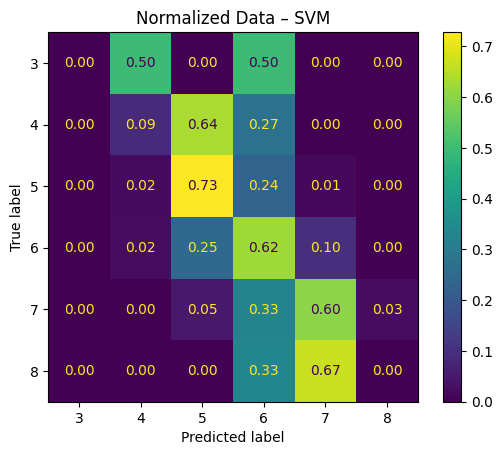

In [24]:
# normalized pipeline
pipe_normalized = SkPipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(random_state=42)),
])

param_grid_normalized = [
    {
        "svm__kernel": ["linear"],
        "svm__C": [0.1, 1, 10, 100],
    },
    {
        "svm__kernel": ["poly"],
        "svm__C": [0.1, 1, 10, 100],
        "svm__gamma": ["scale", "auto", 0.001, 0.01, 0.1],
        "svm__degree": [2, 3],
    },
    {
        "svm__kernel": ["rbf"],
        "svm__C": [0.1, 1, 10, 100],
        "svm__gamma": ["scale", "auto", 0.001, 0.01, 0.1, 1],
    },
    {
        "svm__kernel": ["sigmoid"],
        "svm__C": [0.1, 1, 10, 100],
        "svm__gamma": ["scale", "auto", 0.001, 0.01, 0.1],
    },
]

grid_norm = GridSearchCV(
    pipe_normalized,
    param_grid=param_grid_normalized,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1,
    return_train_score=True,
)

grid_norm.fit(X_train, y_train)

best_idx = grid_norm.best_index_
best_params = grid_norm.best_params_

train_cv_macro_f1_mean = grid_norm.cv_results_["mean_train_score"][best_idx]
train_cv_macro_f1_std = grid_norm.cv_results_["std_train_score"][best_idx]
val_cv_macro_f1_mean = grid_norm.best_score_
val_cv_macro_f1_std = grid_norm.cv_results_["std_test_score"][best_idx]

best_norm = grid_norm.best_estimator_
y_pred_norm = best_norm.predict(X_test)

test_macro_f1 = f1_score(y_test, y_pred_norm, average="macro")
test_acc = accuracy_score(y_test, y_pred_norm)

print("Running normalized pipeline")
print("Best parameters:", best_params)
print(f"Train CV Macro F1 (mean): {train_cv_macro_f1_mean:.4f}")
print(f"Train CV Macro F1 (std):  {train_cv_macro_f1_std:.4f}")
print(f"Val   CV Macro F1 (mean): {val_cv_macro_f1_mean:.4f}")
print(f"Val   CV Macro F1 (std):  {val_cv_macro_f1_std:.4f}")
print(f"\nTest Macro F1: {test_macro_f1:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_norm, zero_division=0))

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_norm, normalize="true", values_format=".2f"
)
plt.title("Normalized Data – SVM")
plt.show()

#### A.1.2.2 PCA Pipeline & Results

Running PCA pipeline
Best parameters: {'svm__C': 10, 'svm__gamma': 'auto', 'svm__kernel': 'rbf'}
Train CV Macro F1 (mean): 0.6657
Train CV Macro F1 (std):  0.0176
Val   CV Macro F1 (mean): 0.3335
Val   CV Macro F1 (std):  0.0830

Test Macro F1: 0.3965
Test Accuracy: 0.6094

Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.14      0.09      0.11        11
           5       0.66      0.71      0.68       136
           6       0.57      0.58      0.57       128
           7       0.66      0.57      0.61        40
           8       0.50      0.33      0.40         3

    accuracy                           0.61       320
   macro avg       0.42      0.38      0.40       320
weighted avg       0.60      0.61      0.60       320



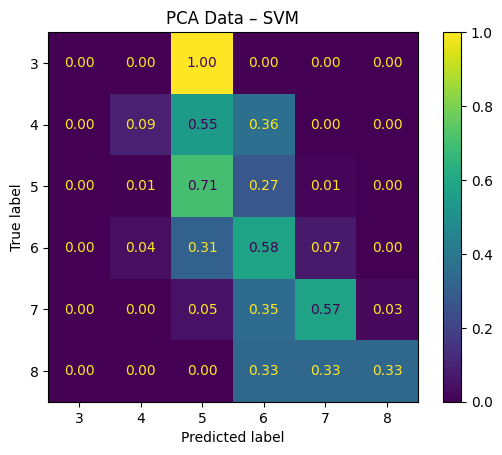

In [25]:
# PCA pipeline
pipe_pca = SkPipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=5)),
    ("svm", SVC(random_state=42)),
])

param_grid_pca = [
    {
        "svm__kernel": ["linear"],
        "svm__C": [0.1, 1, 10, 100],
    },
    {
        "svm__kernel": ["poly"],
        "svm__C": [0.1, 1, 10, 100],
        "svm__gamma": ["scale", "auto", 0.001, 0.01, 0.1],
        "svm__degree": [2, 3],
    },
    {
        "svm__kernel": ["rbf"],
        "svm__C": [0.1, 1, 10, 100],
        "svm__gamma": ["scale", "auto", 0.001, 0.01, 0.1, 1],
    },
    {
        "svm__kernel": ["sigmoid"],
        "svm__C": [0.1, 1, 10, 100],
        "svm__gamma": ["scale", "auto", 0.001, 0.01, 0.1],
    },
]

grid_pca = GridSearchCV(
    pipe_pca,
    param_grid=param_grid_pca,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1,
    return_train_score=True,
)

grid_pca.fit(X_train, y_train)

best_idx = grid_pca.best_index_
best_params_pca = grid_pca.best_params_

train_cv_macro_f1_mean = grid_pca.cv_results_["mean_train_score"][best_idx]
train_cv_macro_f1_std = grid_pca.cv_results_["std_train_score"][best_idx]
val_cv_macro_f1_mean = grid_pca.best_score_
val_cv_macro_f1_std = grid_pca.cv_results_["std_test_score"][best_idx]

best_pca = grid_pca.best_estimator_
y_pred_pca = best_pca.predict(X_test)

test_macro_f1_pca = f1_score(y_test, y_pred_pca, average="macro")
test_acc_pca = accuracy_score(y_test, y_pred_pca)

print("Running PCA pipeline")
print("Best parameters:", best_params_pca)
print(f"Train CV Macro F1 (mean): {train_cv_macro_f1_mean:.4f}")
print(f"Train CV Macro F1 (std):  {train_cv_macro_f1_std:.4f}")
print(f"Val   CV Macro F1 (mean): {val_cv_macro_f1_mean:.4f}")
print(f"Val   CV Macro F1 (std):  {val_cv_macro_f1_std:.4f}")
print(f"\nTest Macro F1: {test_macro_f1_pca:.4f}")
print(f"Test Accuracy: {test_acc_pca:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_pca, zero_division=0))

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_pca, normalize="true", values_format=".2f"
)
plt.title("PCA Data – SVM")
plt.show()

#### A.1.2.3 SMOTE Pipeline & Results

Running SMOTE pipeline
Best parameters: {'svm__C': 10, 'svm__degree': 3, 'svm__gamma': 0.1, 'svm__kernel': 'poly'}
Train CV Macro F1 (mean): 0.7344
Train CV Macro F1 (std):  0.0288
Val   CV Macro F1 (mean): 0.3608
Val   CV Macro F1 (std):  0.0352

Test Macro F1: 0.3701
Test Accuracy: 0.5750

Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.15      0.36      0.21        11
           5       0.68      0.59      0.63       136
           6       0.62      0.57      0.59       128
           7       0.57      0.65      0.60        40
           8       0.12      0.33      0.18         3

    accuracy                           0.57       320
   macro avg       0.36      0.42      0.37       320
weighted avg       0.61      0.57      0.59       320



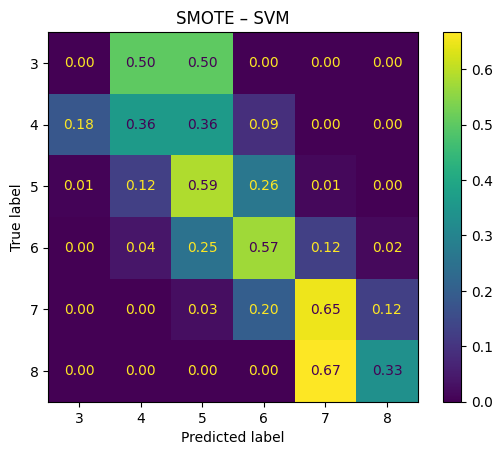

In [26]:
# SMOTE pipeline
pipe_smote = ImbPipeline([
    ("scaler", StandardScaler()),
    ("smote", SMOTE(random_state=42, k_neighbors=3)),
    ("svm", SVC(random_state=42)),
])

param_grid_smote = [
    {
        "svm__kernel": ["linear"],
        "svm__C": [0.1, 1, 10, 100],
    },
    {
        "svm__kernel": ["poly"],
        "svm__C": [0.1, 1, 10, 100],
        "svm__gamma": ["scale", "auto", 0.001, 0.01, 0.1],
        "svm__degree": [2, 3],
    },
    {
        "svm__kernel": ["rbf"],
        "svm__C": [0.1, 1, 10, 100],
        "svm__gamma": ["scale", "auto", 0.001, 0.01, 0.1, 1],
    },
    {
        "svm__kernel": ["sigmoid"],
        "svm__C": [0.1, 1, 10, 100],
        "svm__gamma": ["scale", "auto", 0.001, 0.01, 0.1],
    },
]

grid_smote = GridSearchCV(
    pipe_smote,
    param_grid=param_grid_smote,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1,
    return_train_score=True,
)

grid_smote.fit(X_train, y_train)

best_idx_smote = grid_smote.best_index_
best_params_smote = grid_smote.best_params_

train_cv_macro_f1_mean_sm = grid_smote.cv_results_["mean_train_score"][best_idx_smote]
train_cv_macro_f1_std_sm = grid_smote.cv_results_["std_train_score"][best_idx_smote]
val_cv_macro_f1_mean_sm = grid_smote.best_score_
val_cv_macro_f1_std_sm = grid_smote.cv_results_["std_test_score"][best_idx_smote]

best_smote = grid_smote.best_estimator_
y_pred_smote = best_smote.predict(X_test)

test_macro_f1_smote = f1_score(y_test, y_pred_smote, average="macro")
test_acc_smote = accuracy_score(y_test, y_pred_smote)

print("Running SMOTE pipeline")
print("Best parameters:", best_params_smote)
print(f"Train CV Macro F1 (mean): {train_cv_macro_f1_mean_sm:.4f}")
print(f"Train CV Macro F1 (std):  {train_cv_macro_f1_std_sm:.4f}")
print(f"Val   CV Macro F1 (mean): {val_cv_macro_f1_mean_sm:.4f}")
print(f"Val   CV Macro F1 (std):  {val_cv_macro_f1_std_sm:.4f}")
print(f"\nTest Macro F1: {test_macro_f1_smote:.4f}")
print(f"Test Accuracy: {test_acc_smote:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_smote, zero_division=0))

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_smote, normalize="true", values_format=".2f"
)
plt.title("SMOTE – SVM")
plt.show()